In [78]:
import importlib
from datetime import datetime
import scipy
import anndata as ad
from pytorch_lightning.loggers import TensorBoardLogger
from scipy.optimize import linear_sum_assignment
from anndata import AnnData
import warnings
import os
from scipy.sparse import issparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import PCA
from pathlib import Path
import scvi
from sklearn.manifold import TSNE

importlib.reload(scvi)
import re
from scvi.model import SCVI
from scvi.train import TrainingPlan
import torch

import bar_nick_utils
importlib.reload(bar_nick_utils)

from bar_nick_utils import plot_latent, \
    compute_pairwise_kl, select_gene_likelihood, \
    clean_uns_for_h5ad, plot_normalized_losses, compute_pairwise_kl_two_items, get_latest_file, get_mixing_score, \
    match_datasets

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
np.set_printoptions(threshold=100)
np.random.seed(0)
save_dir = 'data'
plot_flag = True


In [79]:
torch.cuda.is_available()

True

In [80]:
folder = 'data/'
file_prefixes = ['adata_rna_', 'adata_prot_', 'adata_archetype_rna_', 'adata_archetype_prot_']



# Load the latest files
latest_files = {prefix: get_latest_file(folder, prefix) for prefix in file_prefixes}
print(latest_files)
adata_rna = sc.read(latest_files['adata_rna_'])
adata_prot = sc.read(latest_files['adata_prot_'])
adata_archetype_rna = sc.read(latest_files['adata_archetype_rna_'])
adata_archetype_prot = sc.read(latest_files['adata_archetype_prot_'])

{'adata_rna_': 'data/adata_rna_2025-02-06-01-02-33.h5ad', 'adata_prot_': 'data/adata_prot_2025-02-06-01-02-33.h5ad', 'adata_archetype_rna_': 'data/adata_archetype_rna_2025-02-06-01-02-33.h5ad', 'adata_archetype_prot_': 'data/adata_archetype_prot_2025-02-06-01-02-33.h5ad'}


In [81]:
sample_size = min(len(adata_prot), len(adata_rna), 500)
adata_rna_subset = sc.pp.subsample(adata_rna, n_obs=sample_size, copy=True)
adata_prot_subset = sc.pp.subsample(adata_prot, n_obs=int(sample_size)-1, copy=True)
del adata_prot, adata_rna

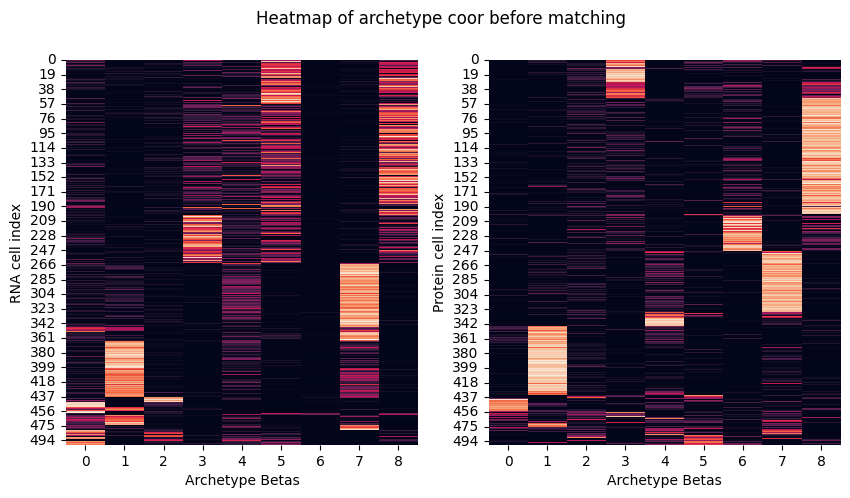

In [82]:
# order cells by major and minor cell type for easy visualization
new_order_rna = adata_rna_subset.obs.sort_values(by=['major_cell_types', 'cell_types']).index
new_order_prot = adata_prot_subset.obs.sort_values(by=['major_cell_types', 'cell_types']).index
adata_rna_subset = adata_rna_subset[new_order_rna]
adata_prot_subset = adata_prot_subset[new_order_prot]
archetype_distances = scipy.spatial.distance.cdist(adata_rna_subset.obsm['archetype_vec'].values,
                                               adata_prot_subset.obsm['archetype_vec'].values,metric='cosine')
matching_distance_before = np.diag(archetype_distances).mean()

if plot_flag:
    plt.figure(figsize=(10, 5))
    plt.suptitle('Heatmap of archetype coor before matching')
    plt.subplot(1, 2, 1)
    sns.heatmap(np.log1p(adata_rna_subset.obsm['archetype_vec'].values), cbar=False)
    plt.ylabel('RNA cell index')
    plt.xlabel('Archetype Betas')
    plt.subplot(1, 2, 2)
    sns.heatmap(np.log1p(adata_prot_subset.obsm['archetype_vec'].values), cbar=False)
    plt.xlabel('Archetype Betas')
    plt.ylabel('Protein cell index')
    plt.show()

Matching Report:
- Matched 431/500 adata1 cells (69 unmatched)
- Used 316/499 adata2 cells (183 never matched)
- adata2 reuses: 115
- Average match distance before matching:0.422
- Average match distance after matching: 0.036


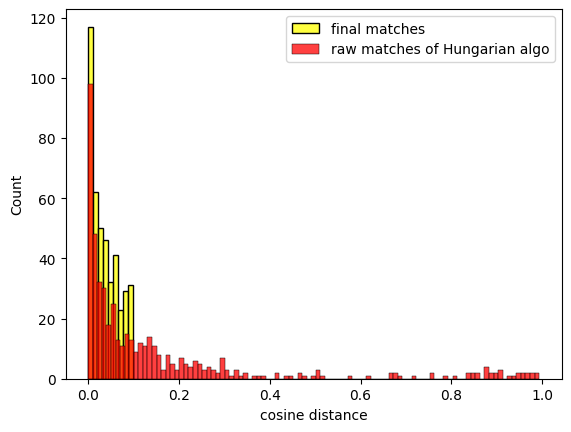

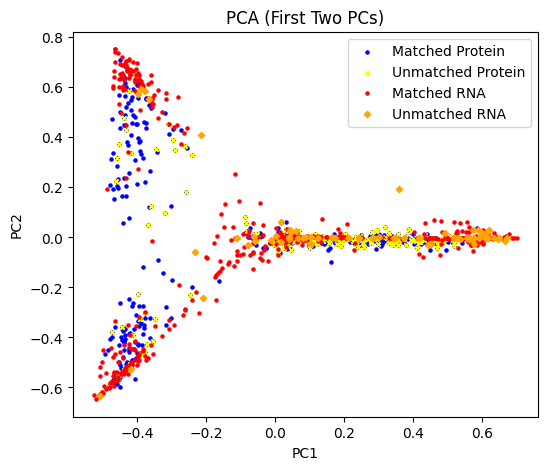

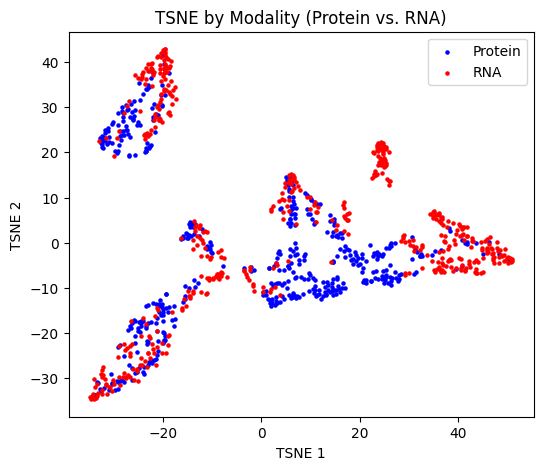

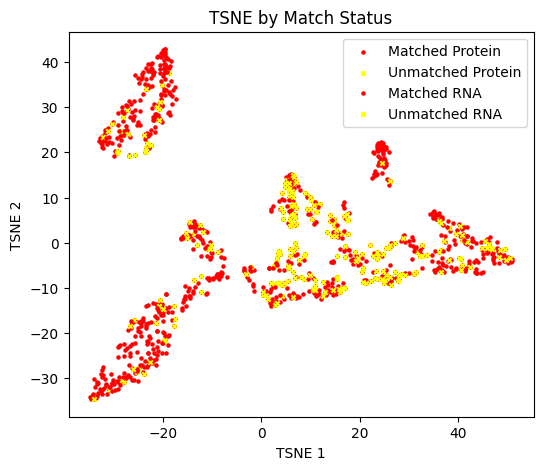

In [83]:

adata_rna_subset_matched,adata_prot_subset_matched = match_datasets(adata_rna_subset,adata_prot_subset,0.1,plot_flag=plot_flag)

adata_rna_subset,adata_prot_subset = adata_rna_subset_matched,adata_prot_subset_matched

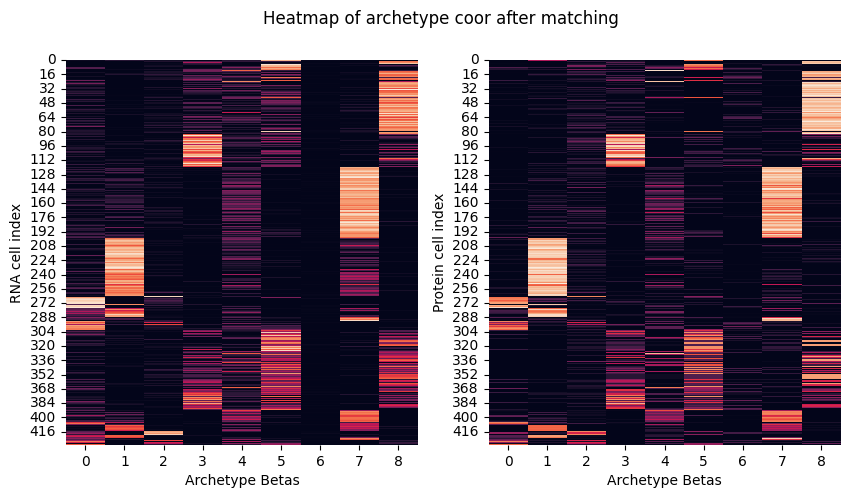

In [84]:
if plot_flag:
    plt.figure(figsize=(10, 5))
    plt.suptitle('Heatmap of archetype coor after matching')
    plt.subplot(1, 2, 1)
    sns.heatmap(np.log1p(adata_rna_subset.obsm['archetype_vec'].values), cbar=False)
    plt.ylabel('RNA cell index')
    plt.xlabel('Archetype Betas')
    plt.subplot(1, 2, 2)
    sns.heatmap(np.log1p(adata_prot_subset.obsm['archetype_vec'].values), cbar=False)
    plt.ylabel('Protein cell index')
    plt.xlabel('Archetype Betas')

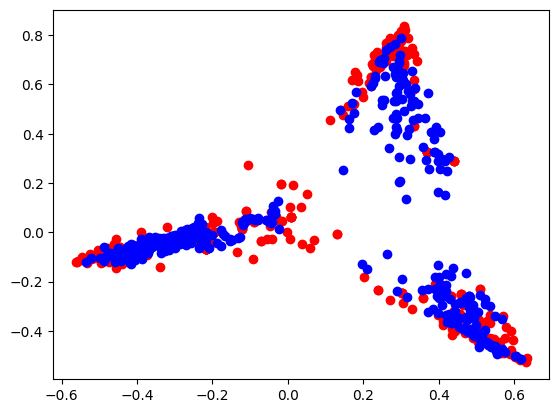

In [85]:
if plot_flag:
    a = adata_prot_subset.obsm['archetype_vec']
    b = adata_rna_subset.obsm['archetype_vec']
    pca = PCA(n_components=2)
    pca.fit(b)
    a_pca = pca.transform(a)
    b_pca = pca.transform(b)
    plt.scatter(a_pca[:, 0], a_pca[:, 1], c='r')
    plt.scatter(b_pca[:, 0], b_pca[:, 1], c='b')
    plt.show()

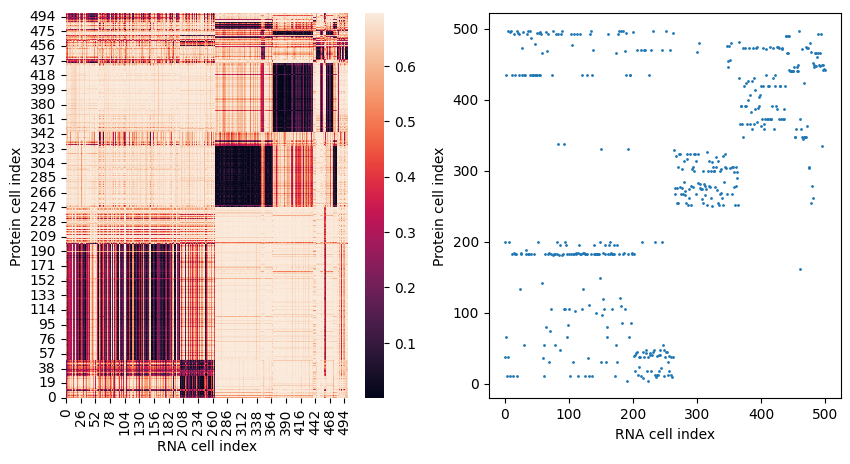

In [86]:
if plot_flag:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    sns.heatmap(np.log1p(archetype_distances[:9000, :9000].T))
    plt.xlabel('RNA cell index')
    plt.ylabel('Protein cell index')
    plt.gca().invert_yaxis()

    plt.subplot(1, 2, 2)
    plt.scatter(
        np.arange(len(archetype_distances.argmin(axis=1))),
        archetype_distances.argmin(axis=1),
        s=1,
        rasterized=True
    )
    plt.xlabel('RNA cell index')
    plt.ylabel('Protein cell index')
    # plt.title('If this looks like a line, then the matching ARE THE SAME AND NOT ACROSS MODALITIES')
    plt.show()


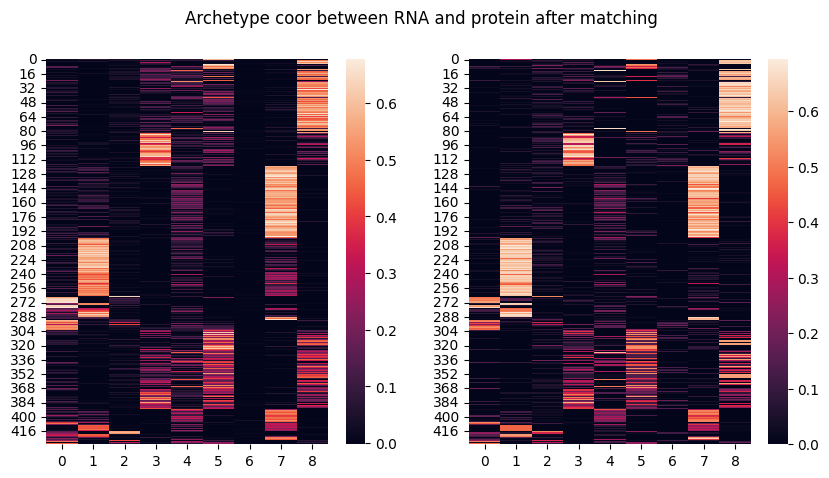

In [87]:
if plot_flag:
    plt.figure(figsize=(10, 5))
    plt.suptitle('Archetype coor between RNA and protein after matching')
    plt.subplot(1, 2, 1)
    sns.heatmap(np.log1p(adata_rna_subset.obsm['archetype_vec'].values))
    plt.subplot(1, 2, 2)
    sns.heatmap(np.log1p(adata_prot_subset.obsm['archetype_vec'].values))
    plt.show()

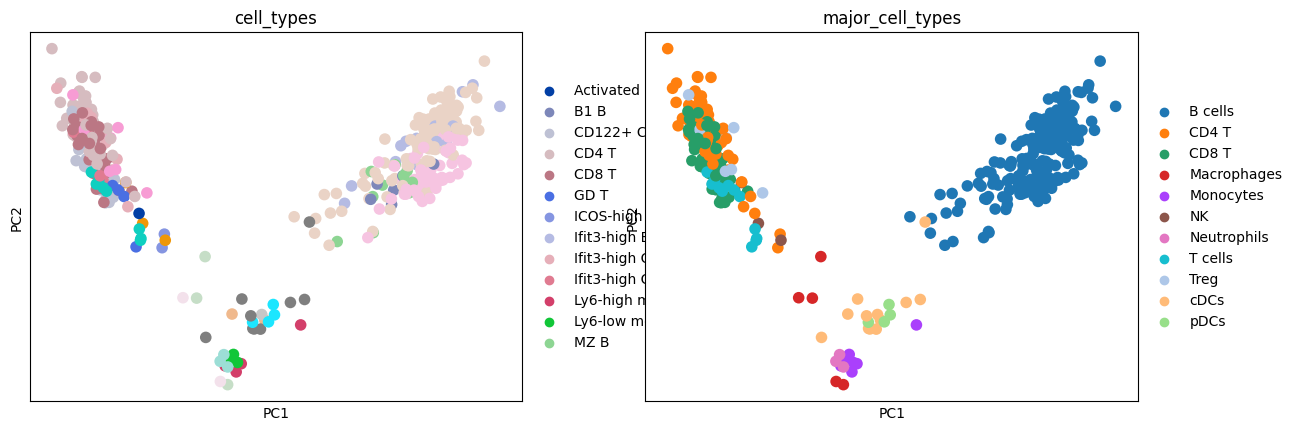

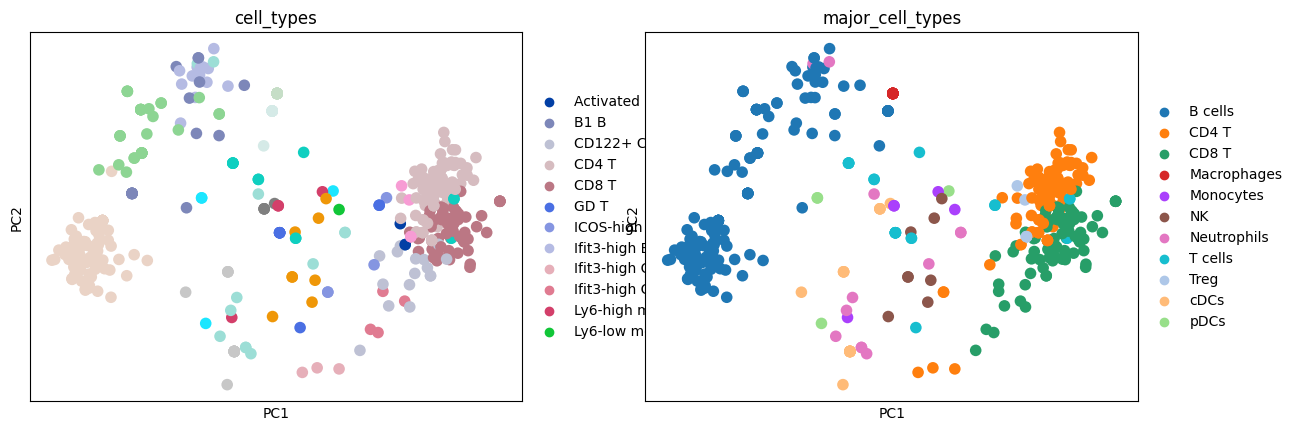

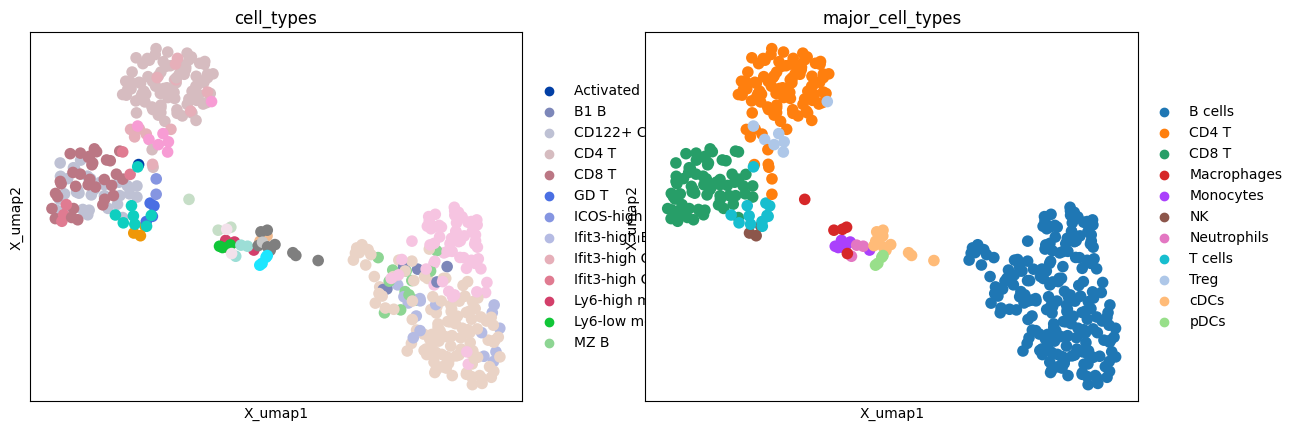

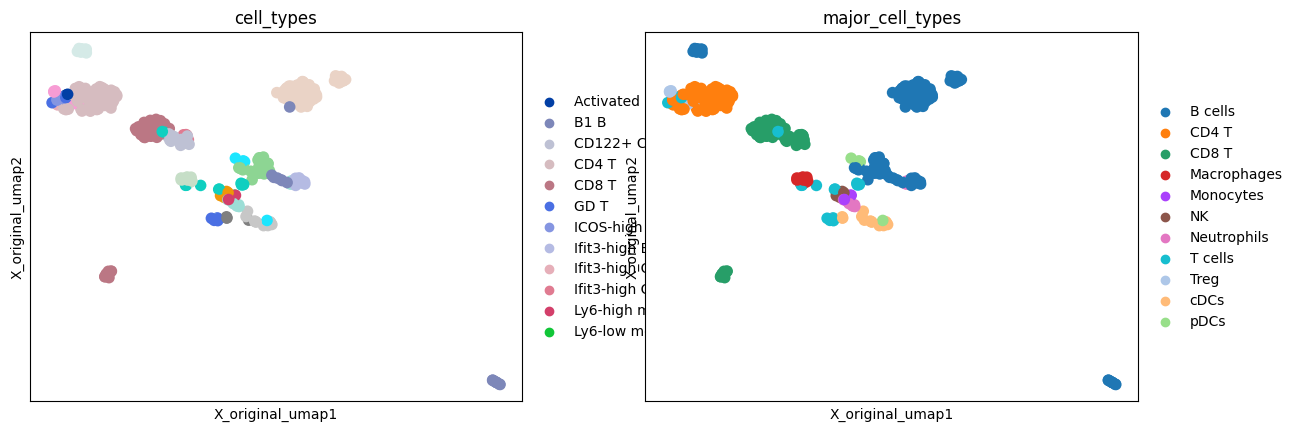

In [88]:
sc.pp.pca(adata_rna_subset, n_comps=50)
sc.pp.pca(adata_prot_subset, n_comps=50)
sc.pp.neighbors(adata_rna_subset, key_added='original_neighbors')
sc.tl.umap(adata_rna_subset, neighbors_key='original_neighbors')
adata_rna_subset.obsm['X_original_umap'] = adata_rna_subset.obsm["X_umap"]
sc.pp.neighbors(adata_prot_subset, key_added='original_neighbors')
sc.tl.umap(adata_prot_subset, neighbors_key='original_neighbors')
adata_prot_subset.obsm['X_original_umap'] = adata_prot_subset.obsm["X_umap"]

if plot_flag:
    sc.pl.pca(adata_rna_subset, color=['cell_types', 'major_cell_types'])
    sc.pl.pca(adata_prot_subset, color=['cell_types', 'major_cell_types'])
    sc.pl.embedding(adata_rna_subset, basis='X_umap', color=['cell_types', 'major_cell_types'])
    sc.pl.embedding(adata_prot_subset, basis='X_original_umap', color=['cell_types', 'major_cell_types'])


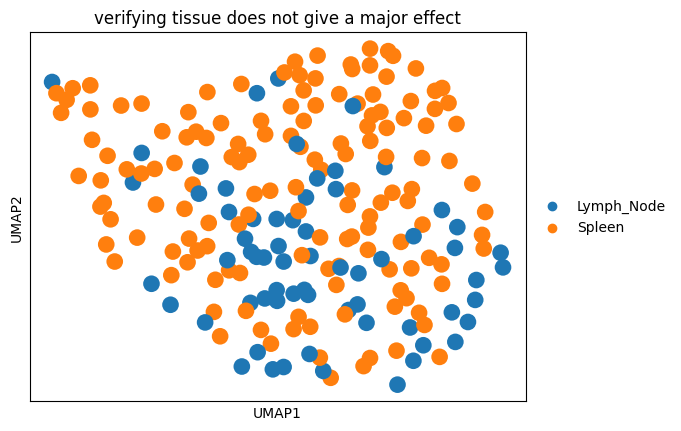

In [89]:
if plot_flag:
    adata_B_cells = adata_rna_subset[adata_rna_subset.obs['major_cell_types'] == 'B cells']
    sc.pp.pca(adata_B_cells)
    sc.pp.neighbors(adata_B_cells, use_rep='X_pca')
    sc.tl.umap(adata_B_cells)
    sc.pl.umap(adata_B_cells, color=['tissue'], title='verifying tissue does not give a major effect')


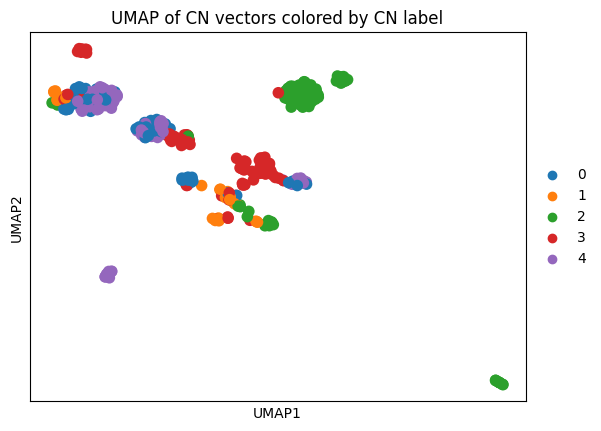

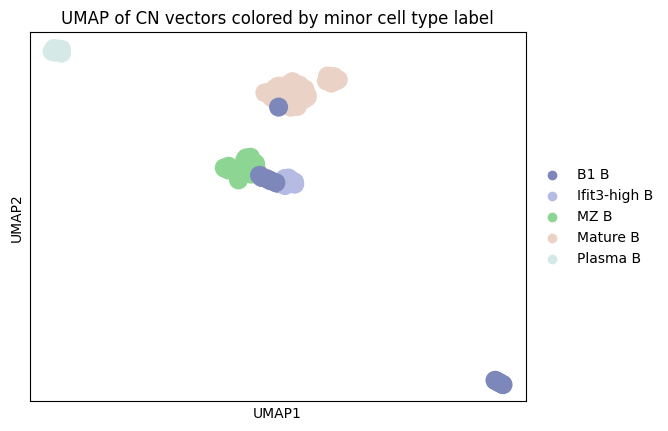

AnnData object with n_obs × n_vars = 431 × 220
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'X', 'Y', 'CN', 'archetype_label', 'index_col'
    var: 'feature_type'
    uns: 'CN_colors', 'archetype_label_colors', 'archetypes', 'cell_types_colors', 'log1p', 'major_cell_types_colors', 'neighbors', 'original_neighbors', 'pca', 'spatial_clusters_colors', 'umap', 'ordered_matching_cells', 'X_neighborhood'
    obsm: 'X_original_umap', 'X_pca', 'X_spatial', 'X_umap', 'archetype_vec', 'spatial_location'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'original_neighbors_connectivities', 'original_neighbors_distances', 'X_neighborhood_distances', 'X_neighborhood_connectivities'

In [90]:
sc.pp.neighbors(adata_prot_subset, use_rep='X_pca', key_added='X_neighborhood')
sc.tl.umap(adata_prot_subset, neighbors_key='X_neighborhood')
adata_prot_subset.obsm['X_original_umap'] = adata_prot_subset.obsm["X_umap"]
sc.pl.umap(adata_prot_subset, color='CN', title='UMAP of CN vectors colored by CN label',
           neighbors_key='original_neighbors', )
sc.pl.umap(adata_prot_subset[adata_prot_subset.obs['major_cell_types'] == 'B cells'], color='cell_types',
           title='UMAP of CN vectors colored by minor cell type label')
adata_prot_subset

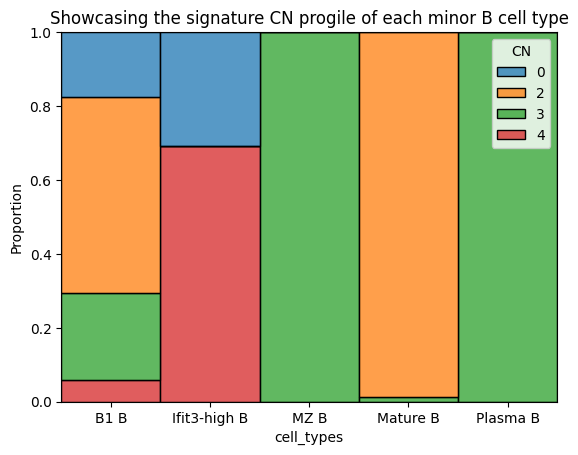

In [91]:
if plot_flag:
    sns.histplot(adata_prot_subset[adata_prot_subset.obs['major_cell_types'] == 'B cells'].obs, x='cell_types',
                 hue='CN', multiple='fill', stat='proportion')
    # sns.histplot(adata_prot_subset.obs, x='cell_types',hue='CN', multiple='fill', stat='proportion')
    plt.title('Showcasing the signature CN progile of each minor B cell type')

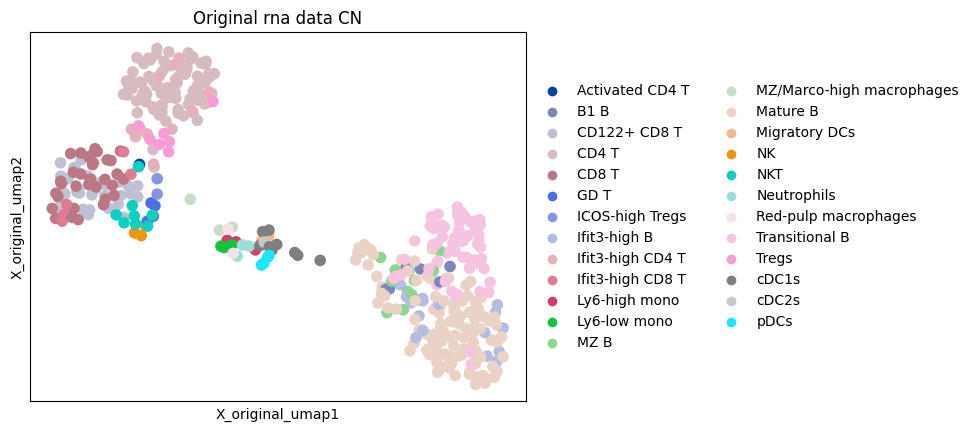

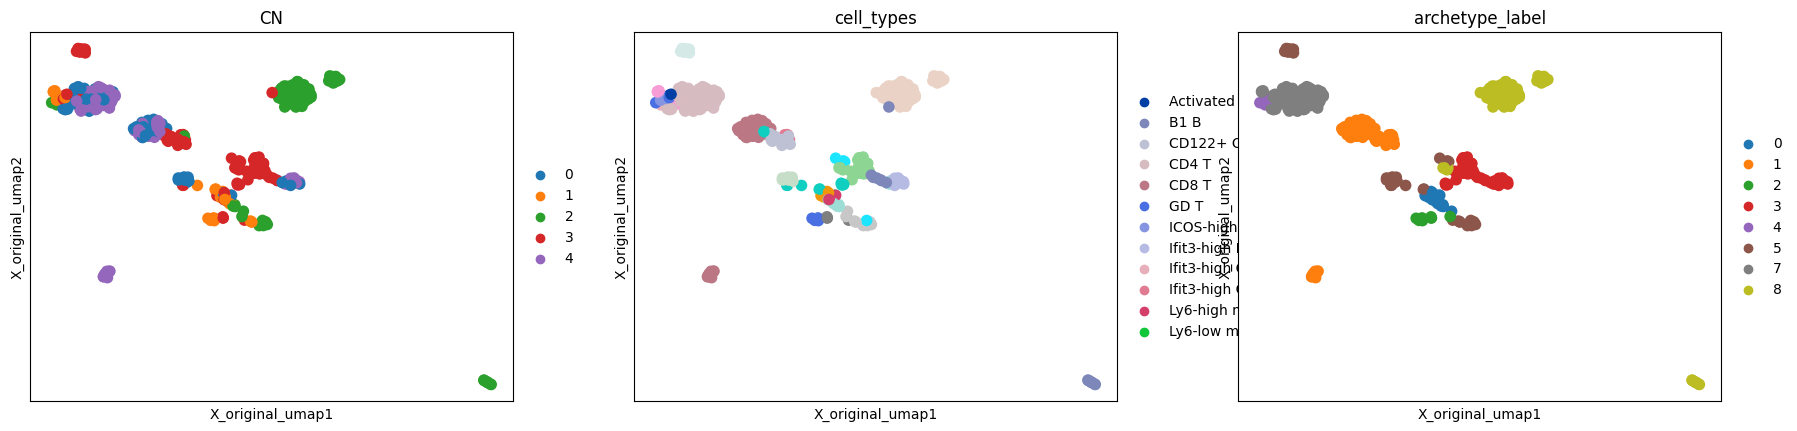

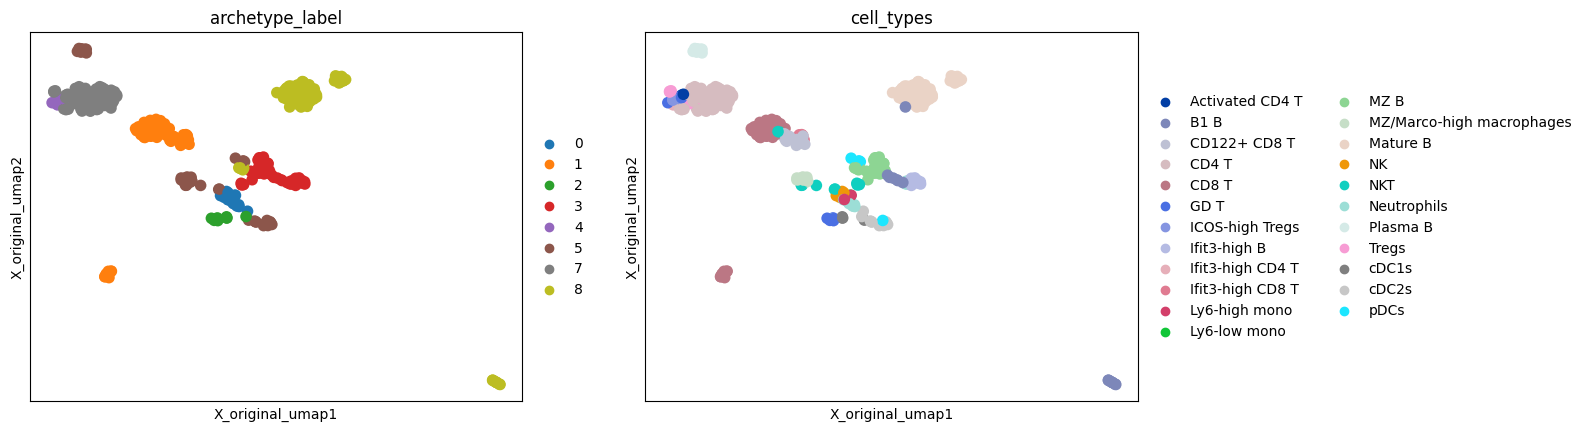

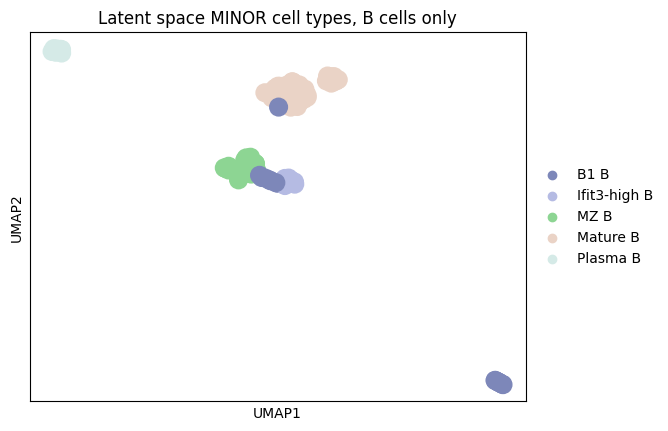

In [92]:
if plot_flag:
    # sc.pl.embedding(adata_rna_subset, color=["major_cell_types","cell_types"], basis='X_original_umap',title='Original data major minor cell types')
    # sc.pl.embedding(adata_prot_subset, color=["major_cell_types","cell_types"], basis='X_original_umap',title='Original data major and minor cell types')

    # sc.pl.umap(adata_rna_subset, color="CN",neighbors_key='original_neighbors',title='Original RNA data CN')
    sc.pl.embedding(adata_rna_subset, color=[ "cell_types"], basis='X_original_umap', title='Original rna data CN')
    # sc.pl.embedding(adata_rna_subset, color=["CN","cell_types"],basis='X_original_umap',title='Original rna data CN')
    # sc.pl.umap(adata_prot_subset, color="CN",neighbors_key='original_neighbors',title='Original protein data CN')
    sc.pl.embedding(adata_prot_subset, color=["CN", "cell_types", 'archetype_label'], basis='X_original_umap')
    sc.pl.embedding(adata_prot_subset, color=['archetype_label', "cell_types", ], basis='X_original_umap')
    sc.pl.umap(adata_prot_subset[adata_prot_subset.obs['major_cell_types'] == 'B cells'], color="cell_types",
               neighbors_key='original_neighbors', title='Latent space MINOR cell types, B cells only')



In [93]:
# DO NOT DELETE - save the adata of external processing
# adata_rna_subset = sc.read('adata_rna_subset.hd5ad')
# adata_prot_subset = sc.read('adata_prot_subset.hd5ad')
clean_uns_for_h5ad(adata_prot_subset)
clean_uns_for_h5ad(adata_rna_subset)
cwd = os.getcwd()
sc.write(
    Path(f'{cwd}/adata_rna_subset'),
    adata_rna_subset)
sc.write(
    Path(f'{cwd}/adata_prot_subset'),
    adata_prot_subset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Selected gene likelihood: zinb


Training:   0%|          | 0/2 [00:00<?, ?it/s]

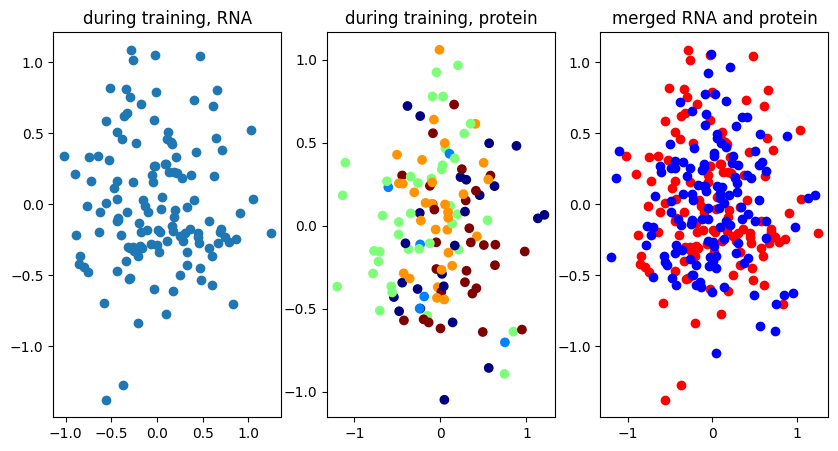

losses are reconstruction_loss:537.2462158203125, contrastive_loss:1.6580017805099487, matching_loss:22185.12109375, total_loss:22724.025390625


`Trainer.fit` stopped: `max_epochs=2` reached.


In [146]:
class DualVAETrainingPlan(TrainingPlan):
    def __init__(self, rna_module, **kwargs):
        protein_vae = kwargs.pop('protein_vae')
        rna_vae = kwargs.pop('rna_vae')
        contrastive_weight = kwargs.pop('contrastive_weight', 1.0)
        # super().__init__(protein_vae.module, **kwargs)
        super().__init__(rna_module, **kwargs)
        self.rna_vae = rna_vae
        self.protein_vae = protein_vae
        self.contrastive_weight = contrastive_weight
        self.protein_vae.module.to(device)
        self.rna_vae.module = self.rna_vae.module.to(device)
        self.first_step = True
        if self.protein_vae.adata.uns.get('ordered_matching_cells') is not True:
            raise ValueError('The cells are not aligned across modalities, make sure ')
        n_samples = len(self.rna_vae.adata)
        steps_per_epoch = int(np.ceil(n_samples / 128))
        self.total_steps = steps_per_epoch * n_epochs

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            list(self.rna_vae.module.parameters()) + list(self.protein_vae.module.parameters()),
            lr=0.001,
            weight_decay=1e-5,
        )
        return optimizer

    def validation_step(self, batch, batch_idx):
        """Validation step for the model."""
        rna_batch = self._get_rna_batch(batch)
        _, _, rna_loss_output = self.rna_vae.module(rna_batch, loss_kwargs=self.loss_kwargs)
        protein_batch = self._get_protein_batch(batch)
        _, _, protein_loss_output = self.protein_vae.module(protein_batch, loss_kwargs=self.loss_kwargs)

        # Inference outputs
        rna_inference_outputs = self.rna_vae.module.inference(
            rna_batch["X"], batch_index=rna_batch["batch"], n_samples=1
        )
        protein_inference_outputs = self.protein_vae.module.inference(
            protein_batch["X"], batch_index=protein_batch["batch"], n_samples=1
        )

        # Compute latent distances
        matching_rna_protein_latent_distances = torch.distributions.kl_divergence(
            rna_inference_outputs["qz"], protein_inference_outputs["qz"]
        )

        # Compute pairwise distances for RNA and protein
        rna_distances = compute_pairwise_kl(
            rna_inference_outputs["qz"].mean, rna_inference_outputs["qz"].scale
        )
        prot_distances = compute_pairwise_kl(
            protein_inference_outputs["qz"].mean, protein_inference_outputs["qz"].scale
        )

        # Retrieve cell neighborhood information
        index = rna_batch["labels"]
        cell_neighborhood_info = torch.tensor(
            self.protein_vae.adata[index].obs["CN"].values, device=device
        )
        rna_major_cell_type = torch.tensor(
            self.rna_vae.adata[index].obs["major_cell_types"].values.codes, device=device
        ).squeeze()
        protein_major_cell_type = torch.tensor(
            self.rna_vae.adata[index].obs["major_cell_types"].values.codes, device=device
        ).squeeze()

        num_cells = cell_neighborhood_info.shape[0]
        diagonal_mask = torch.eye(num_cells, dtype=torch.bool, device=device)

        same_cn_mask = cell_neighborhood_info.unsqueeze(0) == cell_neighborhood_info.unsqueeze(1)
        same_major_cell_type_mask = rna_major_cell_type.unsqueeze(0) == protein_major_cell_type.unsqueeze(1)

        # Use protein distances or a combination as needed
        distances = prot_distances + rna_distances
        distances = distances.masked_fill(diagonal_mask, 0)

        # Define loss masks
        same_major_type_same_cn_loss = (distances ** 2) * (same_major_cell_type_mask & same_cn_mask)
        same_major_type_different_cn_loss = ((10 - distances).clamp(min=0) ** 2) * (
                same_major_cell_type_mask & ~same_cn_mask
        )
        different_major_type_same_cn_loss = ((10 - distances).clamp(min=0) ** 2) * (
                ~same_major_cell_type_mask & same_cn_mask
        )
        different_major_type_different_cn_loss = ((10 - distances).clamp(min=0) ** 2) * (
                ~same_major_cell_type_mask & ~same_cn_mask
        )

        cn_loss = (
                          same_major_type_same_cn_loss.sum()
                          + same_major_type_different_cn_loss.sum()
                          + different_major_type_same_cn_loss.sum()
                          + different_major_type_different_cn_loss.sum()
                  ) / (num_cells * (num_cells - 1))

        total_loss = (
                0.1 * self.contrastive_weight * cn_loss
                + 0.1 * rna_loss_output.loss
                + 0.1 * protein_loss_output.loss
                + 10 * matching_rna_protein_latent_distances.mean()
        )

        # Log metrics
        self.log(
            "validation_rna_loss", rna_loss_output.loss, on_epoch=True, sync_dist=self.use_sync_dist
        )
        self.log(
            "validation_protein_loss", protein_loss_output.loss, on_epoch=True, sync_dist=self.use_sync_dist
        )
        self.log(
            "validation_contrastive_loss", cn_loss, on_epoch=True, sync_dist=self.use_sync_dist
        )
        self.log(
            "validation_total_loss", total_loss, on_epoch=True, sync_dist=self.use_sync_dist
        )
        self.log(
            "validation_matching_latent_distances", matching_rna_protein_latent_distances.mean(),
            on_epoch=True, sync_dist=self.use_sync_dist
        )

        # Compute and log additional metrics
        self.compute_and_log_metrics(rna_loss_output, self.val_metrics, "validation")
        self.compute_and_log_metrics(protein_loss_output, self.val_metrics, "validation")

        return total_loss

    def training_step(self, batch, batch_idx):
        rna_batch = self._get_rna_batch(batch)
        kl_weight = 2  # maybe make sure this is proper
        self.loss_kwargs.update({"kl_weight": kl_weight})
        self.log("kl_weight", kl_weight, on_step=True, on_epoch=False)
        _, _, rna_loss_output = self.rna_vae.module(rna_batch, loss_kwargs=self.loss_kwargs)
        protein_batch = self._get_protein_batch(batch)
        _, _, protein_loss_output = self.protein_vae.module(protein_batch, loss_kwargs=self.loss_kwargs)

        rna_inference_outputs = self.rna_vae.module.inference(
            rna_batch["X"], batch_index=rna_batch["batch"], n_samples=1
        )
        index = rna_batch["labels"]
        # assert len(set(self.protein_vae.adata[index].obs['CN'].values)) != 1# should this be commented out?

        protein_inference_outputs = self.protein_vae.module.inference(
            protein_batch["X"], batch_index=protein_batch["batch"], n_samples=1
        )
        # here we assume that the cells have been aligned in the same order to their best match across modalities (check adata_prot_subset.uns['ordered_matching_cells'])
        # matching_rna_protein_latent_distances = torch.distributions.kl_divergence(rna_inference_outputs["qz"],
        #                                                                           protein_inference_outputs["qz"])
        # matching_rna_protein_latent_distances = compute_pairwise_kl_two_items(rna_inference_outputs["qz"].mean,
        #                                                                       protein_inference_outputs["qz"].mean,
        #                                                                       rna_inference_outputs["qz"].scale,
        #                                                                       protein_inference_outputs["qz"].scale)

        dis = scipy.spatial.distance.cdist(
            rna_batch['archetype_vec'],
            protein_batch['archetype_vec'],
            metric='cosine'
        )

        latent_distances = torch.cdist(rna_inference_outputs["qz"].mean,
                                       protein_inference_outputs["qz"].mean,
                                       p=2)
        dis_tensor = torch.tensor(dis, dtype=torch.float, device=latent_distances.device)

        threshold = 0.2
        squared_diff = (latent_distances - dis_tensor)**2

        # Identify pairs that are close in the original space and remain close in the latent space
        acceptable_range_mask = (dis_tensor < threshold) & (latent_distances < threshold)

        # Compute the basic stress loss
        stress_loss = squared_diff.mean()

        # Count how many pairs are acceptable
        num_pairs = squared_diff.numel() - latent_distances.size(0)  # if excluding diagonals
        num_acceptable = acceptable_range_mask.sum()

        # Define a reward strength
        reward_strength = 0.001  # adjust as needed

        # Apply the reward by subtracting from the loss based on how many acceptable pairs we have
        reward = reward_strength * (num_acceptable.float() / num_pairs)
        matching_loss = stress_loss - reward
        rna_distances = compute_pairwise_kl(rna_inference_outputs["qz"].mean,
                                            rna_inference_outputs["qz"].scale)
        prot_distances = compute_pairwise_kl(protein_inference_outputs["qz"].mean,
                                             protein_inference_outputs["qz"].scale)
        distances = 5* prot_distances + rna_distances
        if self.first_step:  # show the mask only for the first batch to make sure it is working as expected
            # plot_inference_outputs(rna_inference_outputs, protein_inference_outputs,
            #                        matching_rna_protein_latent_distances, rna_distances, prot_distances)
            # Assume rna_mean, protein_mean, adata_rna_subset, adata_prot_subset, and index are defined

            self.first_step = False

        if self.global_step > -1 and self.global_step % max(int(self.total_steps / 1),0) == 0:
            # verify_gradients(self.rna_vae.module,self.protein_vae)
            # sns.histplot(prot_distances.detach().cpu().flatten(), label='prot')
            # sns.histplot(rna_distances.detach().cpu().flatten(), label='rna')
            # plt.legend()
            # plt.show()
            plot_latent(rna_inference_outputs["qz"].mean.clone().detach().cpu().numpy(),
                        protein_inference_outputs["qz"].mean.clone().detach().cpu().numpy(),
                        self.rna_vae.adata, self.protein_vae.adata, index=rna_batch["labels"])
        cell_neighborhood_info = torch.tensor(self.protein_vae.adata[index].obs["CN"].values).to(device)
        rna_major_cell_type = torch.tensor(self.rna_vae.adata[index].obs["major_cell_types"].values.codes).to(
            device).squeeze()
        protein_major_cell_type = torch.tensor(self.rna_vae.adata[index].obs["major_cell_types"].values.codes).to(
            device).squeeze()

        num_cells = self.rna_vae.adata[index].shape[0]
        # this will give us each row represents a item in the array, and each col is whether it is the same as the items in that index of the col
        # this way we get for each cell(a row) which other cells (index of each item in the row, which is the col) are matching
        # so if we got 1,2,1, we will get [[1,0,1],[0,1,0],[1,0,1]]
        same_cn_mask = cell_neighborhood_info.unsqueeze(0) == cell_neighborhood_info.unsqueeze(1)
        same_major_cell_type = rna_major_cell_type.unsqueeze(0) == protein_major_cell_type.unsqueeze(1)
        diagonal_mask = torch.eye(num_cells, dtype=torch.bool, device=cell_neighborhood_info.device)

        distances = distances.masked_fill(diagonal_mask, 0)

        same_major_type_same_cn_mask = (same_major_cell_type * same_cn_mask).type(torch.bool)
        same_major_type_different_cn_mask = (same_major_cell_type * ~same_cn_mask).type(torch.bool)
        different_major_type_same_cn_mask = (~same_major_cell_type * same_cn_mask).type(torch.bool)
        different_major_type_different_cn_mask = (~same_major_cell_type * ~same_cn_mask).type(torch.bool)

        same_major_type_same_cn_mask.masked_fill_(diagonal_mask, 0)
        same_major_type_different_cn_mask.masked_fill_(diagonal_mask, 0)
        different_major_type_same_cn_mask.masked_fill_(diagonal_mask, 0)
        different_major_type_different_cn_mask.masked_fill_(diagonal_mask, 0)

        same_major_type_same_cn_loss = (distances ** 2) * same_major_type_same_cn_mask
        same_major_type_different_cn_loss = ((10 - distances).clamp(min=0) ** 2) * same_major_type_different_cn_mask
        different_major_type_same_cn_loss = ((10 - distances).clamp(min=0) ** 2) * different_major_type_same_cn_mask
        different_major_type_different_cn_loss = ((10 - distances).clamp(
            min=0) ** 2) * different_major_type_different_cn_mask
        # for debugging only: #
        same_cn_loss = (distances ** 2) * same_cn_mask
        same_major_type_loss = (distances ** 2) * same_major_cell_type
        # end of debugging
        positive_loss = same_major_type_same_cn_loss

        negative_loss = different_major_type_different_cn_loss + different_major_type_same_cn_loss + 2 * same_major_type_different_cn_loss
        cn_loss = (positive_loss.sum() + negative_loss.sum()) / (num_cells * (num_cells - 1))

        matching_loss = 10000 * matching_loss.mean()
        reconstruction_loss = rna_loss_output.loss * 0.1 + protein_loss_output.loss * 0.1
        contrastive_loss = 0.01 * self.contrastive_weight * cn_loss
        total_loss = (
                reconstruction_loss
                + contrastive_loss
                + matching_loss
        )
        # Log losses
        self.log("train_rna_reconstruction_loss", rna_loss_output.loss, on_epoch=False, on_step=True)
        self.log("train_protein_reconstruction_loss", protein_loss_output.loss, on_epoch=False, on_step=True)
        self.log("train_contrastive_loss", contrastive_loss, on_epoch=False, on_step=True)
        self.log("train_matching_rna_protein_loss", matching_loss, on_epoch=False, on_step=True)
        self.log("train_total_loss", total_loss, on_epoch=False, on_step=True)
        if (self.global_step > -1 and self.global_step % max(int(self.total_steps / 10), 100) == 0):
            print(
                f'losses are reconstruction_loss:{reconstruction_loss}, contrastive_loss:{contrastive_loss}, matching_loss:{matching_loss}, total_loss:{total_loss}')
        # self.saved_model = False if (self.current_epoch % 49 == 0) else True
        # if self.current_epoch % 50 == 0 and self.saved_model:
        #     print('sved model')
        #     rna_vae.save(save_dir, prefix=f'batch_{self.current_epoch}_', save_anndata=False, overwrite=True)
        #     self.saved_model =True
        return total_loss

    def _get_protein_batch(self, batch):
        indices = batch['labels'].detach().cpu().numpy().flatten()  # Assuming batch contains indices
        protein_data = self.protein_vae.adata[indices]
        protein_batch = {
            'X': torch.tensor(protein_data.X.toarray() if issparse(protein_data.X) else protein_data.X).to(device),
            'batch': torch.tensor(protein_data.obs['_scvi_batch'].values, dtype=torch.long).to(device),
            'labels': indices,
            'archetype_vec': protein_data.obsm['archetype_vec']
        }
        return protein_batch

    def _get_rna_batch(self, batch):
        indices = batch['labels'].detach().cpu().numpy().flatten()
        rna_data = self.rna_vae.adata[indices]
        rna_batch = {
            'X': torch.tensor(rna_data.X.toarray() if issparse(rna_data.X) else rna_data.X).to(device),
            'batch': torch.tensor(rna_data.obs['_scvi_batch'].values, dtype=torch.long).to(device),
            'labels': indices,
            'archetype_vec': rna_data.obsm['archetype_vec']

        }
        return rna_batch


SCVI.setup_anndata(
    adata_rna_subset,
    labels_key="index_col",
)

SCVI.setup_anndata(
    adata_prot_subset,
    labels_key="index_col",
)

# Initialize VAEs
rna_vae = scvi.model.SCVI(adata_rna_subset, gene_likelihood=select_gene_likelihood(adata_rna_subset), n_hidden=128,
                          n_layers=1)
protein_vae = scvi.model.SCVI(adata_prot_subset, gene_likelihood="normal", n_hidden=50, n_layers=1)
initial_weights = {name: param.clone() for name, param in rna_vae.module.named_parameters()}

rna_vae._training_plan_cls = DualVAETrainingPlan
protein_vae._training_plan_cls = DualVAETrainingPlan
protein_vae.module.to('cpu')
rna_vae.module.to('cpu')
rna_vae.is_trained = protein_vae.is_trained = True
latent_rna_before = rna_vae.get_latent_representation().copy()
latent_prot_before = protein_vae.get_latent_representation().copy()
rna_vae.is_trained = protein_vae.is_trained = False

# Create a TensorBoard logger
# It will create a folder nam   ed "my_logs" with subfolders for each run.
logger = TensorBoardLogger(save_dir="my_logs", name=f"experiment_name_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
n_epochs = 2
rna_vae.train(  # for debug only1
    check_val_every_n_epoch=1,
    max_epochs=n_epochs,
    early_stopping=False,
    early_stopping_patience=70,
    early_stopping_monitor="train_total_loss",
    batch_size=256,
    shuffle_set_split=True,
    plan_kwargs={'protein_vae': protein_vae,
                 'rna_vae': rna_vae,
                 'contrastive_weight': 10.0,
                 },
    # logger=logger  # Pass logger directly, not within another dictionary
)

In [142]:
adata_rna_subset.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 112055 stored elements and shape (431, 2000)>

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/200 [00:00<?, ?it/s]

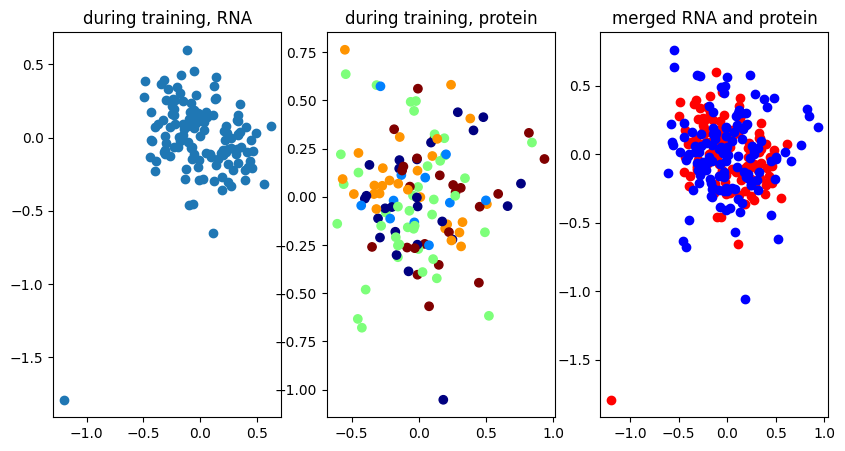

losses are reconstruction_loss:428.0618896484375, contrastive_loss:2.4740707874298096, matching_loss:2794.51318359375, total_loss:3225.049072265625
losses are reconstruction_loss:244.77406311035156, contrastive_loss:1.9360992908477783, matching_loss:1051.10888671875, total_loss:1297.819091796875
losses are reconstruction_loss:229.64450073242188, contrastive_loss:1.4092708826065063, matching_loss:657.4107055664062, total_loss:888.4644775390625
losses are reconstruction_loss:219.19140625, contrastive_loss:1.4505279064178467, matching_loss:480.23193359375, total_loss:700.8739013671875
losses are reconstruction_loss:215.96078491210938, contrastive_loss:1.0465258359909058, matching_loss:385.416259765625, total_loss:602.423583984375
losses are reconstruction_loss:210.095703125, contrastive_loss:1.0262174606323242, matching_loss:324.179443359375, total_loss:535.3013916015625
losses are reconstruction_loss:205.7332000732422, contrastive_loss:0.9791809320449829, matching_loss:327.190185546875, 

`Trainer.fit` stopped: `max_epochs=200` reached.


In [147]:

rna_vae.is_trained = protein_vae.is_trained = False
n_epochs =200

rna_vae.train(
    check_val_every_n_epoch=20,
    max_epochs=n_epochs,
    early_stopping=False,

    # early_stopping_patience=70,
    # early_stopping_monitor="train_total_loss",
    batch_size=5000,
    plan_kwargs={'protein_vae': protein_vae,
                 'rna_vae': rna_vae,
                 'contrastive_weight': 10.0,
                 },
    # logger=logger  # Pass logger directly, not within another dictionary

)
protein_vae.is_trained = rna_vae.is_trained = True

In [148]:
protein_vae.is_trained = rna_vae.is_trained = True
if 'train_total_loss' not in rna_vae.history.keys():
    raise Exception('make sure you did not run the training twice (in the same cell as the custom training plan)')

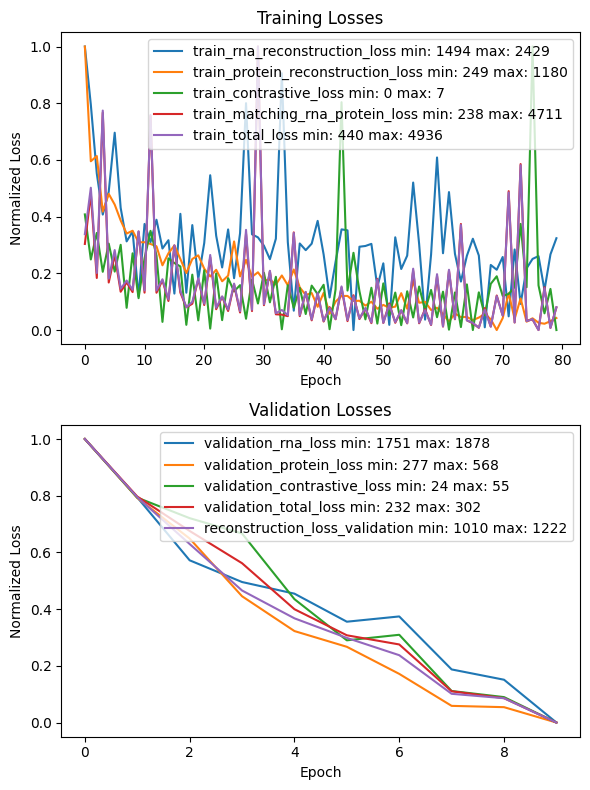

In [149]:
plot_normalized_losses(rna_vae.history)
# plot_aligned_normalized_losses(rna_vae.history)

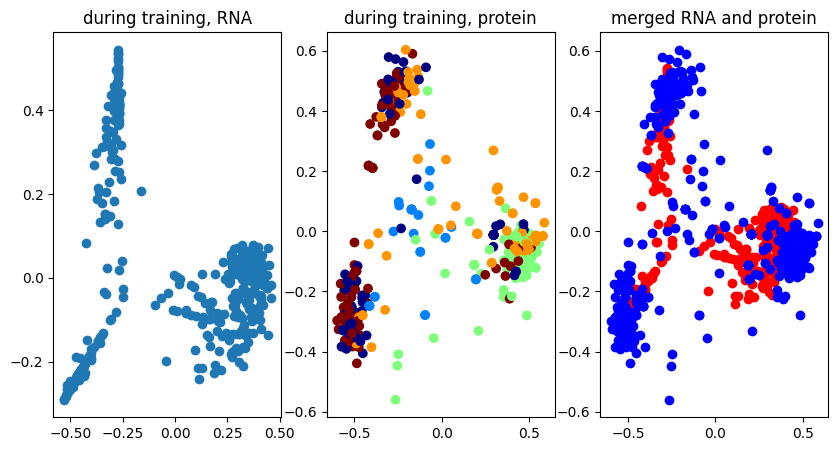

In [155]:
SCVI_LATENT_KEY = "X_scVI"
rna_vae.module.to(device)
protein_vae.module.to(device)
rna_vae.module.eval()
protein_vae.module.eval()

protein_vae.is_trained = True
with torch.no_grad():
    # latent_rna = rna_vae.get_latent_representation()
    # latent_prot = protein_vae.get_latent_representation()
    
    latent_rna = rna_vae.module.inference(
    torch.tensor(adata_rna_subset.X.todense()), batch_index=1, n_samples=1
    )["qz"].mean.clone().detach().cpu().numpy()


    latent_prot = protein_vae.module.inference(
    torch.tensor(adata_prot_subset.X), batch_index=1, n_samples=1
    )["qz"].mean.clone().detach().cpu().numpy()
    plot_latent(latent_rna, latent_prot, adata_rna_subset, adata_prot_subset,index=range(len(adata_prot_subset.obs.index)))


adata_rna_subset.obsm[SCVI_LATENT_KEY] = latent_rna
adata_prot_subset.obsm[SCVI_LATENT_KEY] = latent_prot
# Set up neighbors and UMAP for RNA and protein subsets
sc.pp.neighbors(adata_rna_subset, key_added='latent_space_neighbors', use_rep=SCVI_LATENT_KEY)
adata_rna_subset.obsm['X_umap_scVI'] = adata_rna_subset.obsm['X_umap']
sc.tl.umap(adata_rna_subset, neighbors_key='latent_space_neighbors')

sc.pp.neighbors(adata_prot_subset, key_added='latent_space_neighbors', use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata_prot_subset, neighbors_key='latent_space_neighbors')
adata_prot_subset.obsm['X_umap_scVI'] = adata_prot_subset.obsm['X_umap']

# PCA and UMAP for archetype vectors
rna_latent = AnnData(adata_rna_subset.obsm[SCVI_LATENT_KEY].copy())
prot_latent = AnnData(adata_prot_subset.obsm[SCVI_LATENT_KEY].copy())
rna_latent.obs = adata_rna_subset.obs.copy()
prot_latent.obs = adata_prot_subset.obs.copy()

# Combine the two AnnData objects
combined_latent = ad.concat([rna_latent, prot_latent], join='outer', label='modality', keys=['RNA', 'Protein'])
combined_major_cell_types=pd.concat((adata_rna_subset.obs['major_cell_types']
,adata_prot_subset.obs['major_cell_types']),join='outer')
combined_latent.obs['major_cell_types']=combined_major_cell_types
# sc.pp.pca(combined_latent)
sc.pp.pca(combined_latent)
sc.pp.neighbors(combined_latent)
sc.tl.umap(combined_latent)

rna_archtype = AnnData(adata_rna_subset.obsm['archetype_vec'])
rna_archtype.obs = adata_rna_subset.obs
sc.pp.neighbors(rna_archtype)
sc.tl.umap(rna_archtype)

prot_archtype = AnnData(adata_prot_subset.obsm['archetype_vec'])
prot_archtype.obs = adata_prot_subset.obs
sc.pp.neighbors(prot_archtype)
sc.tl.umap(prot_archtype)


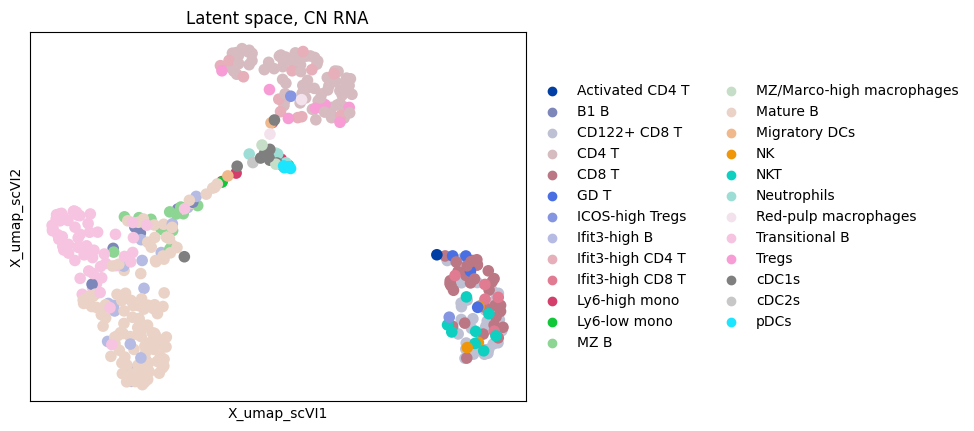

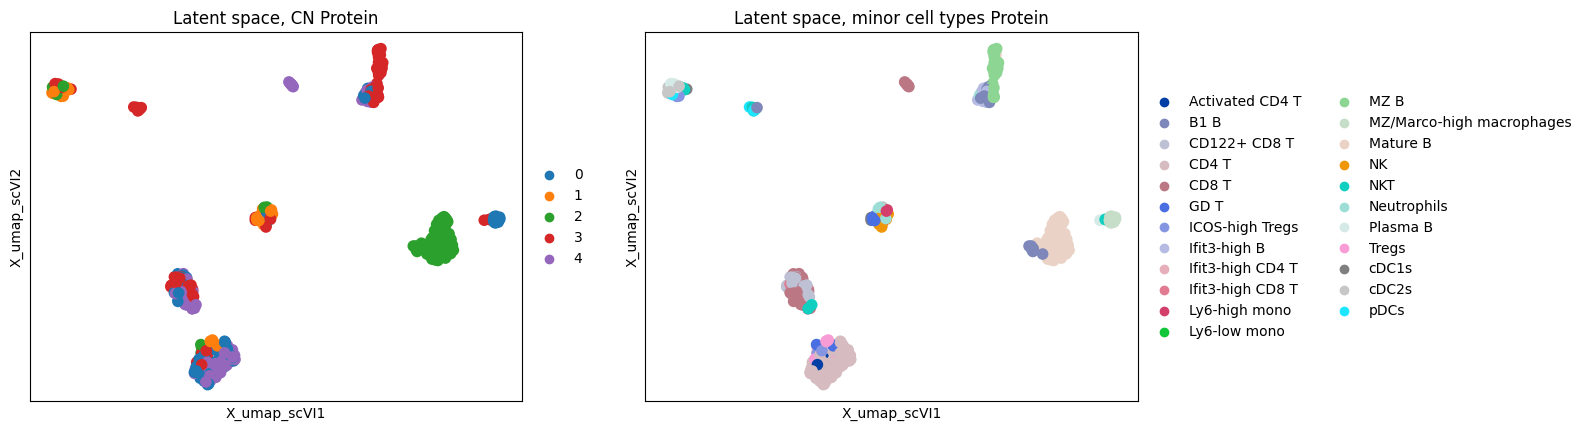

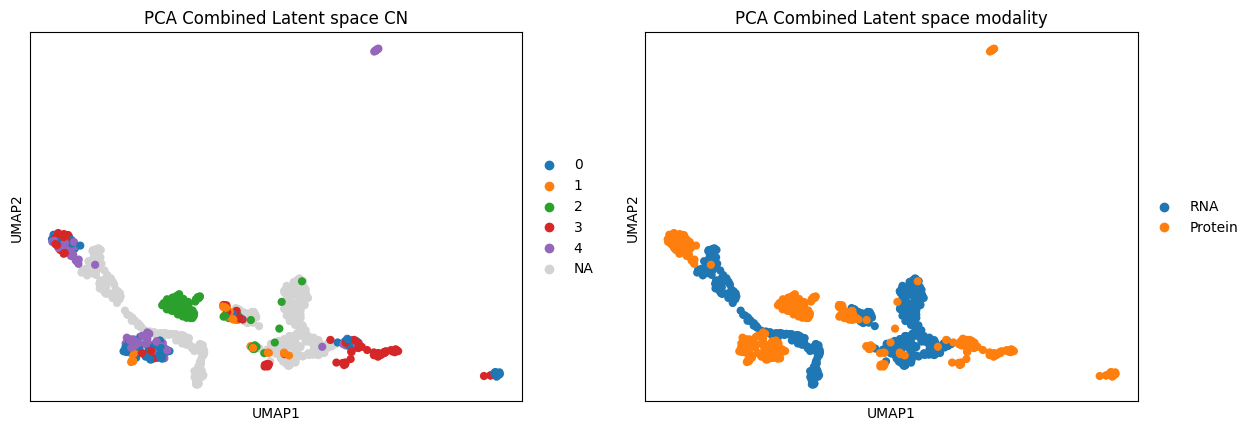

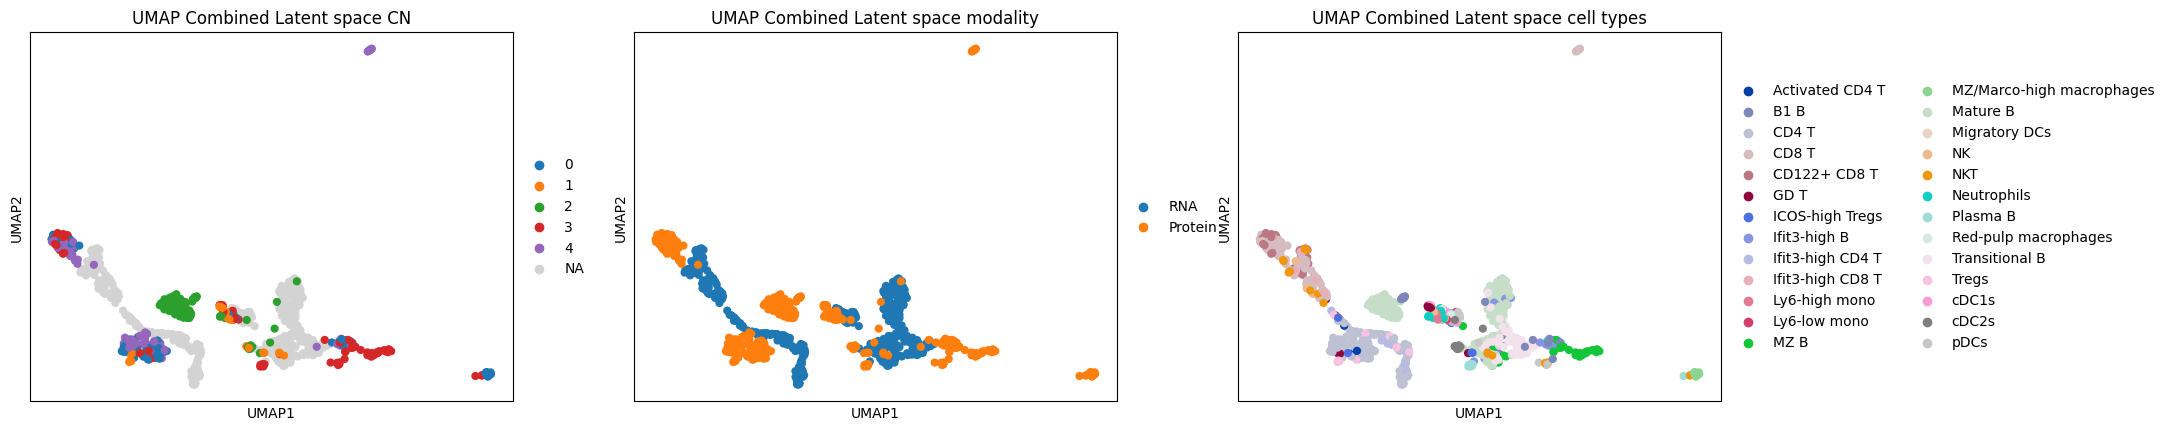

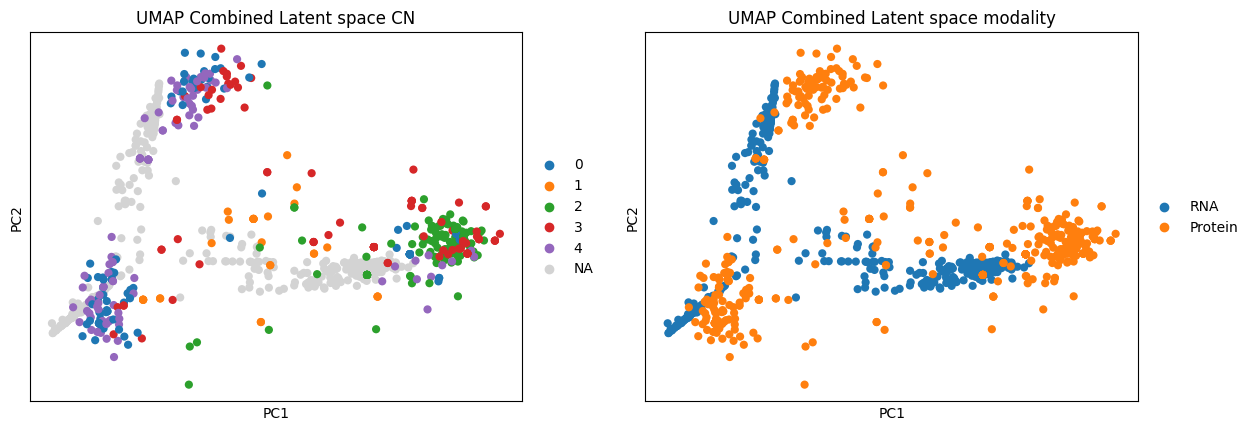

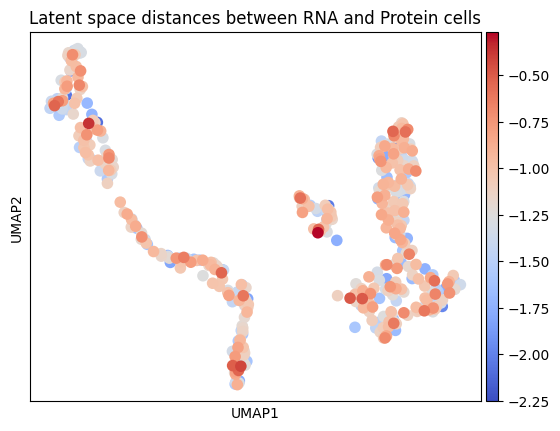

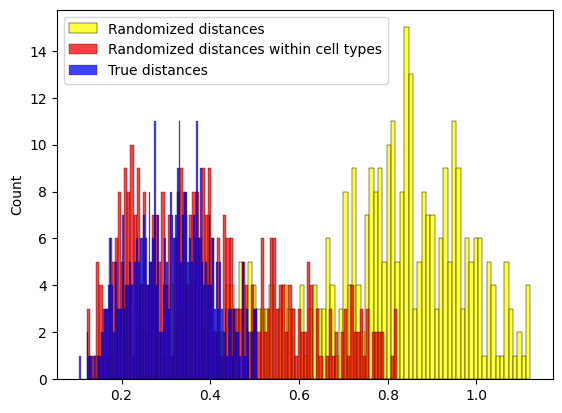

In [156]:

# Combine RNA and protein UMAP plots into two side-by-side plots
sc.pl.embedding(adata_rna_subset, color=[ "cell_types"], basis='X_umap_scVI',
                title=['Latent space, CN RNA', 'Latent space, minor cell types RNA'])
sc.pl.embedding(adata_prot_subset, color=["CN", "cell_types"], basis='X_umap_scVI',
                title=['Latent space, CN Protein', 'Latent space, minor cell types Protein'])

# sc.pl.umap(prot_archtype, color="CN", title='Latent space, CN Protein (Archetype)')
# sc.pl.umap(rna_archtype, color="CN", title='Latent space, CN RNA (Archetype)')

# Combine RNA and Protein latent spaces
sc.pl.umap(combined_latent, color=['CN', 'modality'],
           title=['PCA Combined Latent space CN', 'PCA Combined Latent space modality'])
sc.pl.umap(combined_latent, color=['CN', 'modality', 'cell_types'],
           title=['UMAP Combined Latent space CN', 'UMAP Combined Latent space modality',
                  'UMAP Combined Latent space cell types'])
sc.pl.pca(combined_latent, color=['CN', 'modality'],
          title=['UMAP Combined Latent space CN', 'UMAP Combined Latent space modality'])

# Analyze distances between modalities in the combined latent space
rna_latent = combined_latent[combined_latent.obs['modality'] == 'RNA']
rna_latent.obs['major_cell_types'] = adata_rna_subset.obs['major_cell_types'].values

prot_latent = combined_latent[combined_latent.obs['modality'] == 'Protein']
distances = np.linalg.norm(rna_latent.X - prot_latent.X, axis=1)

# Randomize RNA latent space to compare distances
rand_rna_latent = rna_latent.copy()
shuffled_indices = np.random.permutation(rand_rna_latent.obs.index)
rand_rna_latent = rand_rna_latent[shuffled_indices].copy()
rand_distances = np.linalg.norm(rand_rna_latent.X - prot_latent.X, axis=1)
# Plot randomized latent space distances
rand_rna_latent.obs['latent_dis'] = np.log(distances)

sc.pl.umap(rand_rna_latent, cmap='coolwarm', color='latent_dis',
           title='Latent space distances between RNA and Protein cells')

# Randomize RNA cells within cell types
rand_rna_latent = rna_latent.copy()
for cell_type in rand_rna_latent.obs['major_cell_types'].unique():
    cell_type_indices = rand_rna_latent.obs['major_cell_types'] == cell_type
    shuffled_indices = np.random.permutation(rand_rna_latent[cell_type_indices].obs.index)
    rand_rna_latent.X[cell_type_indices] = rand_rna_latent[cell_type_indices][shuffled_indices].copy().X

rand_distances_cell_type = np.linalg.norm(rand_rna_latent.X - prot_latent.X, axis=1)

# Plot histogram of distances
plt.figure()
sns.histplot(rand_distances[rand_distances < np.percentile(rand_distances, 95)], bins=100, color='yellow',
             label='Randomized distances')
sns.histplot(rand_distances_cell_type[rand_distances_cell_type < np.percentile(rand_distances_cell_type, 95)], bins=100,
             color='red', label='Randomized distances within cell types')
sns.histplot(distances[distances < np.percentile(distances, 95)], bins=100, color='blue', label='True distances')

plt.legend()
plt.show()

# get_mixing_score(combined_latent,batch_key='modality')


In [157]:
combined_latent.obsp

PairwiseArrays with keys: distances, connectivities

In [158]:


a=calculate_iLISI(combined_latent,batch_key='modality')
b =calculate_cLISI(combined_latent,label_key='major_cell_types')
a,b



(1.0, 1.0)

In [159]:
sc.pp.neighbors(combined_latent)
combined_latent


AnnData object with n_obs × n_vars = 862 × 10
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'archetype_label', 'index_col', '_scvi_batch', '_scvi_labels', 'X', 'Y', 'CN', 'modality'
    uns: 'pca', 'neighbors', 'umap', 'CN_colors', 'modality_colors', 'cell_types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [160]:
# plot the CN vector componenst as hue:
# color = adata_prot_subset.var
# cn_cols = adata_prot_subset.var['feature_type']=='CN'
# cn_vec = adata_prot_subset[:,cn_cols.values].X.copy()
# set(adata_prot_subset.var['feature_type'])
# adata_prot_subset.obsm['CN']

In [161]:
# sc.pp.pca(adata_prot_subset)
# # sc.pl.pca(adata_prot_subset, color=["CN", "cell_types"],title=['Latent space, CN Protein', 'Latent space, minor cell types Protein'])
# basis = 'X_umap_scVI'
# sc.pp.neighbors(adata_prot_subset, use_rep=basis)
# sc.tl.umap(adata_prot_subset)
# sc.pl.umap(adata_prot_subset, color=["CN", "cell_types"],
#            title=['Latent space, CN Protein', 'Latent space, minor cell types Protein'])
# aa = adata_prot_subset.obsm[basis]
# # pca on aa and plot
# pca = PCA(n_components=2)
# pca.fit(aa)
# aa_pca = pca.transform(aa)
# plt.scatter(aa_pca[:, 0], aa_pca[:, 1], c=adata_prot_subset.obs['CN'])
# plt.show()

In [162]:
# SCVI_LATENT_KEY = "X_scVI"
# latent = model.get_latent_representation()
# adata_rna_subset.obsm[SCVI_LATENT_KEY] = latent
# 
# sc.pp.neighbors(adata_rna_subset, use_rep=SCVI_LATENT_KEY, key_added='latent_space_neighbors')
# sc.tl.umap(adata_rna_subset, neighbors_key='latent_space_neighbors')
# 
# sc.pl.umap(adata_rna_subset, color="major_cell_types", neighbors_key='latent_space_neighbors',
#            title='Latent space, major cell types')
# sc.pl.umap(adata_rna_subset[adata_rna_subset.obs['major_cell_types'] == 'B cells'], color="CN",
#            neighbors_key='latent_space_neighbors',
#            title='Latent space, minor cell types (B-cells only) with observed CN')
# # B cells only adta
# adata_rna_subset_B_cells = adata_rna_subset[adata_rna_subset.obs['major_cell_types'] == 'B cells']
# adata_prot_subset_B_cells = adata_prot_subset[adata_prot_subset.obs['major_cell_types'] == 'B cells']
# sc.pp.neighbors(adata_rna_subset_B_cells, use_rep=SCVI_LATENT_KEY, key_added='latent_space_neighbors')
# sc.pp.neighbors(adata_prot_subset_B_cells, use_rep='X_pca', key_added='original_neighbors')
# sc.tl.umap(adata_rna_subset_B_cells, neighbors_key='latent_space_neighbors')
# sc.tl.umap(adata_prot_subset_B_cells, neighbors_key='original_neighbors')
# 
# sc.pl.umap(adata_rna_subset_B_cells, color="cell_types", neighbors_key='latent_space_neighbors',
#            title='Latent space minor cell types (B-cells only)')
# sc.pl.umap(adata_prot_subset_B_cells, color="cell_types",
#            neighbors_key='original_neighbors', title='Original Latent space MINOR cell types, B cells only')
# 


In [163]:
# adata_2 = adata_prot_subset[adata_prot_subset.obs['major_cell_types'] == 'B cells']
# sc.pp.pca(adata_2)
# sc.pp.neighbors(adata_2, use_rep='X_pca')
# sc.tl.umap(adata_2)
# sc.pl.umap(adata_2, color='cell_types')


In [164]:
# silhouette_score_per_cell_type_original = {}
# silhouette_score_per_cell_type_latent = {}
# silhouette_score_per_cell_type = {}
# cell_type_indexes = adata_rna_subset.obs['major_cell_types'] == 'B cells'
# cell_type_data = adata_rna_subset[cell_type_indexes].X
# minor_cell_type_lables = adata_rna_subset[cell_type_indexes].obs['cell_types']
# curr_latent = adata_rna_subset.obsm[SCVI_LATENT_KEY][cell_type_indexes]
# 
# silhouette_score_per_cell_type['original_B cells'] = silhouette_score(cell_type_data, minor_cell_type_lables)
# silhouette_score_per_cell_type['Ours B cells'] = silhouette_score(curr_latent, minor_cell_type_lables)
# adata_rna_subset[cell_type_indexes].obs['cell_types']